In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import units as u
from blend_calc import *
from scipy import integrate
from scipy.interpolate import interp1d
from neff_extrapolation import *
from scipy.optimize import curve_fit

mpl.rc('font', family='serif', serif = "cmr10", size=18)
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams["errorbar.capsize"] = 5
mpl.rcParams['axes.unicode_minus'] = False
DIRECTORY = '/mnt/44868D0F868D02A2/Users/veome/Google Drive/Academics/Senior Thesis/Code/Catalog/'

In [2]:
# cosmos = np.genfromtxt(DIRECTORY+'acs_cosmos1361.gcat_ascii', usecols=range(0,10), invalid_raise=False)
cosmos = np.genfromtxt('superbit_cosmos1361_shape_abmag26.5.gcat_ascii', usecols=range(0,13), invalid_raise=False)
# cosmos = np.genfromtxt('superbit19_cosmos1361_lum_mag26.gcat_ascii', usecols=range(0,13), invalid_raise=False)

print("Original Catalog Size: %i"%cosmos.shape[0])

#  Redshift > 0 Cut
cosmos = cosmos[cosmos[:,2]>0] #cut is already in generate_catalog.py
print("New Catalog Size: %i"%cosmos.shape[0])

Original Catalog Size: 488143
New Catalog Size: 488143


In [3]:
# Calculate SuperBIT PSF
lam = 680 * u.nm
theta = 1.22 * lam  * u.rad / (0.5*u.m) # in radians
theta = theta.to(u.arcsec) # in arcsec to combine with jitter
jitter = 0.118 * u.arcsec

psf = np.sqrt(jitter**2 + theta**2)
SUPERBIT_PSF = psf.to(u.arcsec).value # in arcsec
print("SuperBIT PSF: %.3f\"" %SUPERBIT_PSF)

# Calculate SuperBIT PSF for f814W Mags
lam = 814 * u.nm
theta = 1.22 * lam  * u.rad / (0.5*u.m) # in radians
theta = theta.to(u.arcsec) # in arcsec to combine with jitter
jitter = 0.118 * u.arcsec

psf = np.sqrt(jitter**2 + theta**2)
SUPERBIT_F814W_PSF = psf.to(u.arcsec).value # in arcsec
print("SuperBIT F814W PSF: %.3f\"" %SUPERBIT_F814W_PSF)

PIX_TO_ARCSEC = 0.05 # arcsec per HST ACS pixel (Koekemoer et. al. 2007)
ARCSEC_TO_PIX = 1/PIX_TO_ARCSEC # HST ACS pixel per arcsec

SuperBIT PSF: 0.362"
SuperBIT F814W PSF: 0.426"


In [4]:
MAG_MIN = 21.0
MAG_MAX = 26.5

# Extrapolation Theory

Let's say we can only detect background sources which are larger than 1.2 $\cdot$ PSF.

From Richard, etc we know that N ~doubles with mag:
$$ N \propto a^{mag}$$
where $a \sim 2$ from empirical results.

But also, when we convert to another band, we will observe
$$N_{\text{eff}} = f(mag) N$$
where $f(mag)$ is some fraction which we have to determine, and is defined as $$f(mag) = \frac{\text{# of sources at } mag > 1.2 \text{PSF}}{\text{total # of sources at } mag}.$$

Thus, we get the final relation
$$N_{\text{eff}}(mag) = N_0 \cdot 2^{mag} \int_0^{mag} f(mag') \text{ d } mag'$$


We first want to know $f(mag)$, for the SuperBIT Shape band, which we can plot from the catalog data.

The following plot gives the fraction of sources larger than 1.2 times the SuperBIT PSF vs Mag.

# F vs Mag Cut

In [29]:
mags = np.arange(MAG_MIN, MAG_MAX, 0.2)

magcut = np.empty(mags.shape)
magcut_err =  np.empty(mags.shape)

for i in range(mags.shape[0]):
    cat = cosmos
    # perform magcut
    cat = cat[cat[:,5]<=mags[i]]
    n_total = cat.shape[0]
    
    # perform size cut
    cat = cat[cat[:,9] * PIX_TO_ARCSEC > 1.2*SUPERBIT_PSF]
    n_eff = cat.shape[0]
    
    magcut[i] = n_eff / n_total
    magcut_err[i] = np.sqrt((1/ n_total) + (1/n_eff))


# magcut_err = magcut_err * np.std(magcut)

# Interpolated Function
f_magcut = interp1d(mags, magcut)

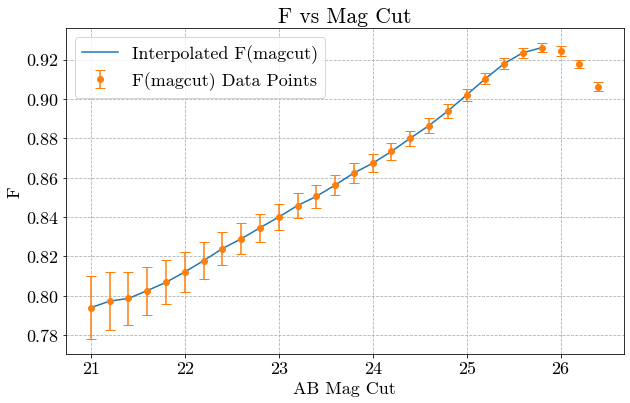

In [30]:
plt.figure(figsize=(10,6))

# Plot the interpolated function
x = np.arange(MAG_MIN, MAG_MAX-0.5, 0.2)
plt.plot(x, f_magcut(x), label='Interpolated F(magcut)')

# Plot the data points
plt.errorbar(mags, magcut, yerr=magcut_err,fmt='o', label='F(magcut) Data Points')

plt.title("F vs Mag Cut")
plt.xlabel("AB Mag Cut")
plt.ylabel('F')
plt.legend()
plt.grid(linestyle='--')
# plt.savefig(DIRECTORY+'f_integrated.png')

# F vs Mag

In [8]:
mags = np.arange(MAG_MIN, MAG_MAX, 0.2)

f_mag_data = np.empty(mags.shape)
f_mag_data_err =  np.empty(mags.shape)

for i in range(mags.shape[0]):
    cat = cosmos
    # perform magcut
    cat = cat[cat[:,5]< mags[i] + 0.1]
    cat = cat[cat[:,5]> mags[i] - 0.1]
    n_total = cat.shape[0]
    
    # perform size cut
    cat = cat[cat[:,9] * PIX_TO_ARCSEC > 1.2*SUPERBIT_PSF]
    n_eff = cat.shape[0]
    
    f_mag_data[i] = n_eff / n_total
    f_mag_data_err[i] = np.sqrt((1/ n_total) + (1/n_eff))

# Interpolation function
f_mag = interp1d(mags, f_mag_data)

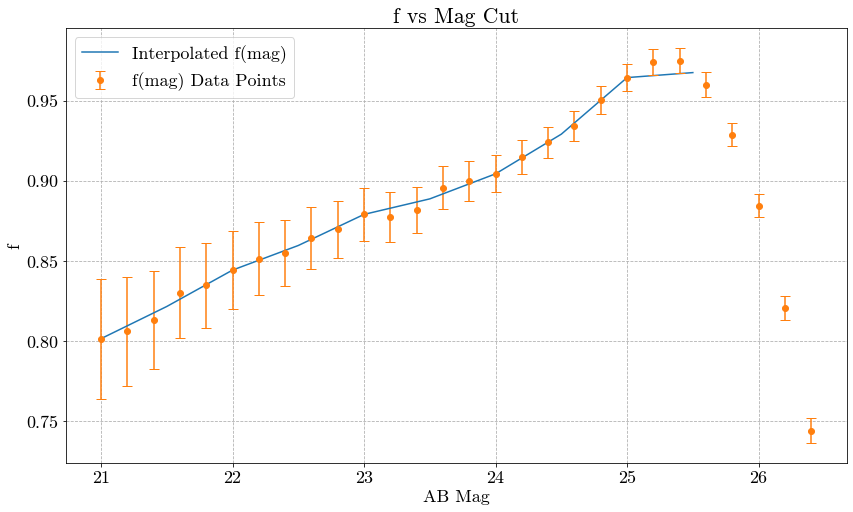

In [35]:
plt.figure(figsize=(14,8))


# Plot the interpolated function
x = np.arange(MAG_MIN, MAG_MAX-0.5, 0.5)

plt.plot(x, f_mag(x), label='Interpolated f(mag)')
# plt.plot(x, f_magcut(x), label='Interpolated F(magcut)')

# Plot the data points
plt.errorbar(mags, f_mag_data, yerr=f_mag_data_err,fmt='o', label='f(mag) Data Points')

plt.title("f vs Mag Cut")
plt.xlabel("AB Mag")
plt.ylabel('f')
plt.legend()
plt.grid(linestyle='--')
# plt.savefig(DIRECTORY+'f_relation.png')

## Integration Test

<ipython-input-10-e0ccc3763381>:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  f_int[i] = integrate.quad(f_mag, MAG_MIN, x[i], points=x[:i])[0]
No handles with labels found to put in legend.


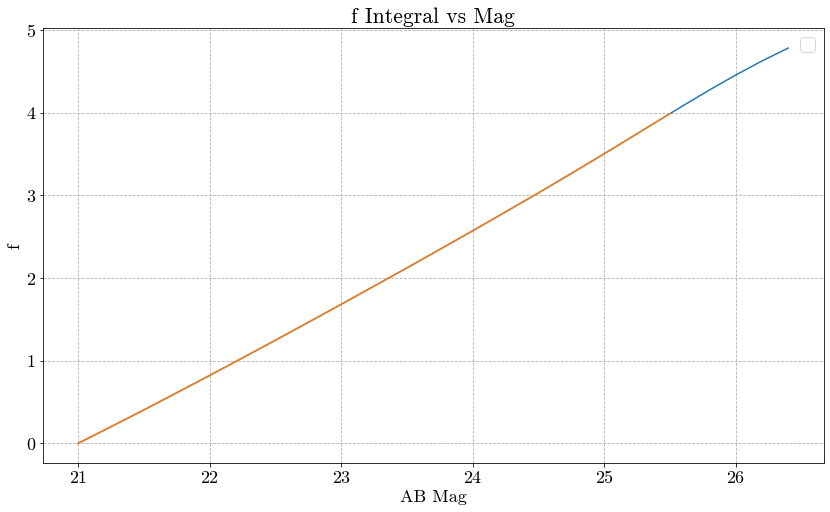

In [10]:
x = np.arange(MAG_MIN, MAG_MAX-0.5, 0.5)
f_int = np.zeros(len(x))

for i in range(len(x)):
    f_int[i] = integrate.quad(f_mag, MAG_MIN, x[i], points=x[:i])[0]

y_int = integrate.cumtrapz(f_mag_data, mags, initial=0)

plt.figure(figsize=(14,8))

plt.plot(mags, y_int)
plt.plot(x, f_int)


plt.title("f Integral vs Mag")
plt.xlabel("AB Mag")
plt.ylabel('f')
plt.legend()
plt.grid(linestyle='--')

# Doubling Relation

Text(0, 0.5, 'N')

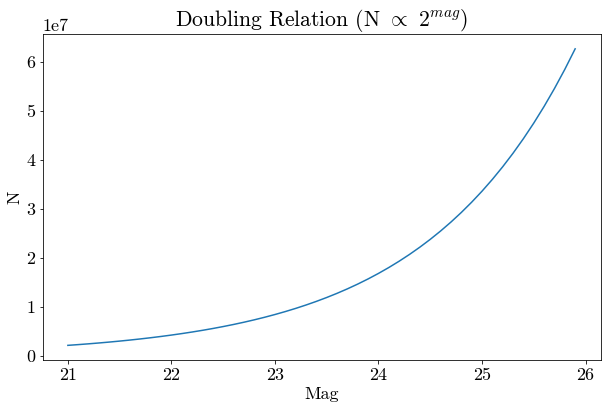

In [11]:
x = np.arange(MAG_MIN, MAG_MAX-0.5, 0.1)
a = 2**x
plt.figure(figsize=(10,6))

plt.plot(x, a)

plt.title("Doubling Relation (N $\propto$ 2$^{mag}$)")
plt.xlabel("Mag")
plt.ylabel('N')

# plt.grid(linestyle='--')



# Combined Function Interpolation

In [12]:
x = np.arange(MAG_MIN, MAG_MAX-0.3, 0.1)
y = 2**x * f_magcut(x)

# Combined function
f = interp1d(x, y)

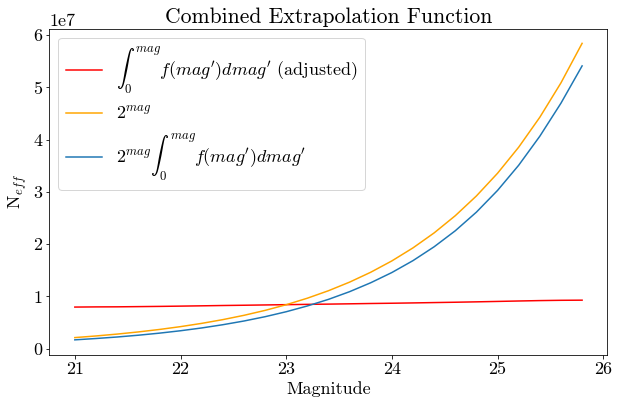

In [31]:
plt.figure(figsize=(10,6))


# Only the Fraction Term
plt.plot(x, 10**7 * f_magcut(x), label='$ \int_0^{mag} f(mag\') d mag\'$ (adjusted)', color='red')

# Only the Doubling Term
plt.plot(x, 2**x, label='$2^{mag}$', color='orange')

# Combined Function
plt.plot(x, f(x), '-', label='$2^{mag} \int_0^{mag} f(mag\') d mag\'$')

plt.legend()
# plt.grid(linestyle='--')
plt.title('Combined Extrapolation Function')
plt.ylabel('N$_{eff}$')
plt.xlabel('Magnitude')
# plt.savefig(DIRECTORY+'extrapolation_function.png')


# Module Test

In [14]:
f_test = get_n_mag(MAG_MIN, MAG_MAX, 0.2, SUPERBIT_PSF, cosmos)

Text(0.5, 1.0, 'Module Test')

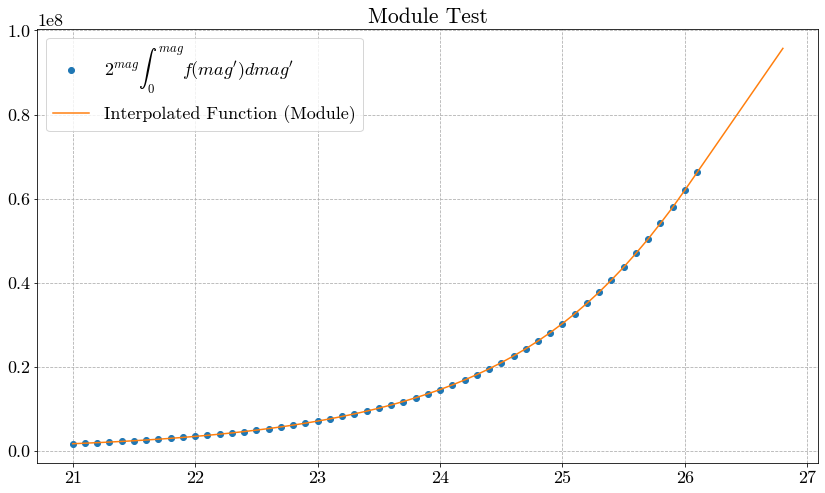

In [15]:
plt.figure(figsize=(14,8))

x = np.arange(MAG_MIN, MAG_MAX-0.3, 0.1)
x1 = np.arange(MAG_MIN, MAG_MAX+0.3, 0.1)
y = 2**x * f_magcut(x)

# Combined function
plt.plot(x, y, 'o', label='$2^{mag} \int_0^{mag} f(mag\') d mag\'$')

# From Module
plt.plot(x1, f_test(x1), label='Interpolated Function (Module)')

plt.legend()
plt.grid(linestyle='--')
plt.title('Module Test')

# Best Fit using Interpolated Function

In [16]:
# Get f for SuperBIT
f_test = get_n_mag(MAG_MIN, MAG_MAX, 0.2, SUPERBIT_PSF, cosmos)

x = np.linspace(MAG_MIN, MAG_MAX, 18)
data = [1.0, 2.0, 2.0, 3.0, 4.0, 5.0, 7.0, 9.0, 11.0, 13.5, 18.0, 22.0, 27.0, 33.0, 41.0, 49.0, 58.0, 67.5] #from hst median data

In [17]:
# Best Fit with Variable Base
best_vals, covar = get_n_fit(x, data, f_test)
print(best_vals)

[7.99454052e-06 9.17703253e-01]


In [18]:
# Best Fit with Base set to 2
def extrapolation(x, amp):
    return amp * 2**x * f_test(x)

init_vals = [1]
best_val_2, covar = curve_fit(extrapolation, x, data, p0=init_vals)
print(best_val_2)

[1.08461036e-14]


In [19]:
# Best Fit with Base set to 10
def new_extrapolation(x, amp, b):
    return amp * 10**(b*x) * f_test(x)

init_vals = [1, 0.4]
best_val_3, covar = curve_fit(new_extrapolation, x, data, p0=init_vals)
print(best_val_3)

[ 7.99454756e-06 -3.72977439e-02]


Amplitude = 7.994540518834577e-06, Exponent Base = 0.9177032525185198
Amplitude = 1.0846103644896925e-14, Exponent Base = 2


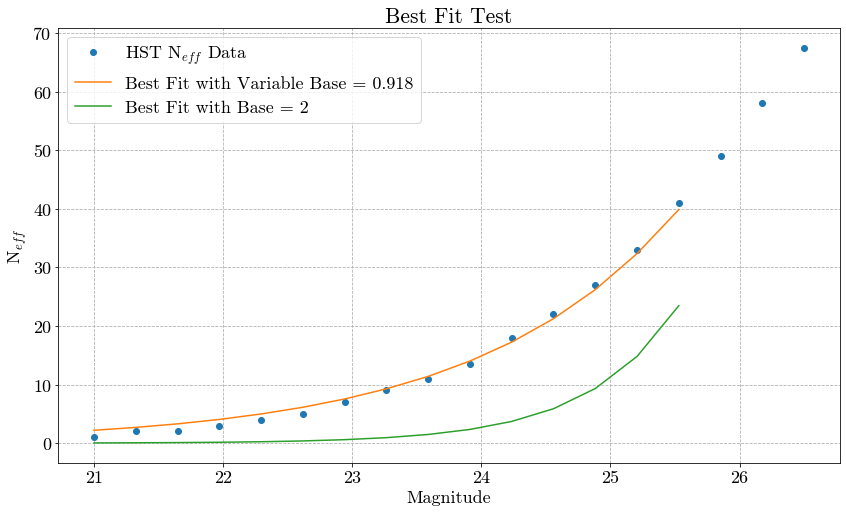

In [21]:
plt.figure(figsize=(14,8))

# Data
plt.plot(x, data, 'o', label='HST N$_{eff}$ Data')

lim = 3

# Best Fit
plt.plot(x[:len(x)-lim], n_extrapolation(x[:len(x)-lim], *best_vals, f_test), label='Best Fit with Variable Base = {:.3f}'.format(best_vals[1]))
plt.plot(x[:len(x)-lim], extrapolation(x[:len(x)-lim], *best_val_2), label='Best Fit with Base = 2')
# plt.plot(x[:len(x)-lim], new_extrapolation(x[:len(x)-lim], *best_val_3), label='Best Fit with Base = 10')

plt.legend()
plt.grid(linestyle='--')
plt.title('Best Fit Test')
plt.xlabel('Magnitude')
plt.ylabel('N$_{eff}$')

# plt.savefig(DIRECTORY+'/Plots/a_fit_test.png')
print("Amplitude = {}, Exponent Base = {}".format(*best_vals))
print("Amplitude = {}, Exponent Base = 2".format(*best_val_2))
# print("Amplitude = {}, Exponent Base = 10^{}".format(*best_val_3))

# Size vs Mag (Complete Catalog)

In [22]:
magcut = 26.5
cat = cosmos[cosmos[:,5]<=magcut]
n_total = cat.shape[0]
n_eff = cat[cat[:,9]>1.2*SUPERBIT_PSF*ARCSEC_TO_PIX].shape[0]
print("Total sources below stmag {}: {}".format(magcut, n_total))
print("Sources below stmag {}, larger than 1.2 x PSF: {}".format(magcut, n_eff))
print("f(magcut): {}".format(n_eff/n_total))

Total sources below stmag 26.5: 488143
Sources below stmag 26.5, larger than 1.2 x PSF: 438977
f(magcut): 0.8992795144045904


(15.0, 26.0)

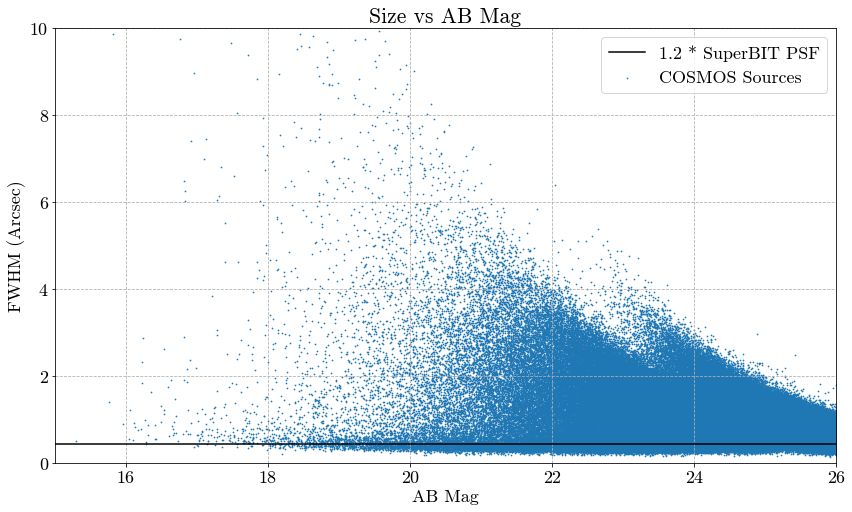

In [23]:
plt.figure(figsize=(14,8))

plt.scatter(cosmos[:,5], cosmos[:,9]*PIX_TO_ARCSEC, s=0.5, label='COSMOS Sources')
plt.plot([0, 26], [1.2*SUPERBIT_PSF, 1.2*SUPERBIT_PSF], 'k-', label='1.2 * SuperBIT PSF')

plt.title("Size vs AB Mag")
plt.xlabel("AB Mag")
plt.ylabel('FWHM (Arcsec)')
plt.legend()
plt.grid(linestyle='--')

plt.ylim(0, 10)
plt.xlim(15, 26)

In [24]:
import matplotlib.cm as cm

In [25]:
norm = mpl.colors.Normalize(vmin=np.min(cosmos[:,2]), vmax=np.max(cosmos[:,2]))
cmap = cm.viridis
m = cm.ScalarMappable(norm=norm, cmap=cmap)

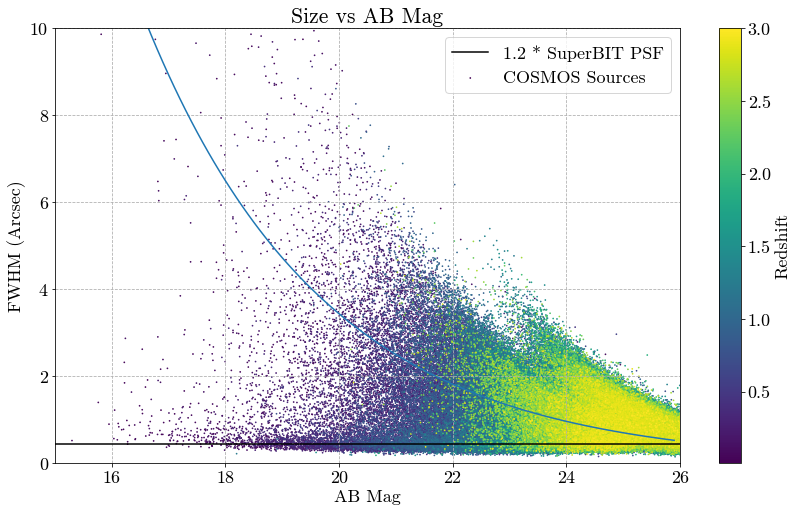

In [33]:
plt.figure(figsize=(14,8))

plt.scatter(cosmos[:,5], cosmos[:,9]*PIX_TO_ARCSEC, s=0.5, c=m.to_rgba(cosmos[:,2]), label='COSMOS Sources')
plt.plot([0, 26], [1.2*SUPERBIT_PSF, 1.2*SUPERBIT_PSF], 'k-', label='1.2 * SuperBIT PSF')

# Manual test fit
x = np.arange(16, 26, 0.1)
y = 2000* np.exp(-x/np.pi) 
plt.plot(x, y)

plt.title("Size vs AB Mag")
plt.xlabel("AB Mag")
plt.ylabel('FWHM (Arcsec)')
plt.legend()
plt.grid(linestyle='--')

plt.clim(np.min(cosmos[:,2]), np.max(cosmos[:,2]))
plt.colorbar(label='Redshift')

plt.ylim(0, 10)
plt.xlim(15, 26)
# plt.savefig(DIRECTORY+'size_vs_mag.png', bbox_inches='tight')
